In [1]:
import os
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 200
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
assert (limit % 8 == 0)

In [7]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
e2 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_2')(e1)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e2)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-24 19:30:23.711288: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-24 19:30:23.725549: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbaa5148670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-24 19:30:23.725562: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [8]:
def calculate_term(e, c0, c1):
    a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
    b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
    return K.dot(K.transpose(a), b)

In [9]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e1, e2, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
        p_loss += (1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
               * calculate_term(e1, c0[i], c1[i])
        p_loss += (1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
               * calculate_term(e2, c0[i], c1[i])
        
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [10]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [11]:
print(len(c0))

28


In [12]:
model.add_loss(my_loss(i2, o, e1, e2, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [13]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(y_true, e, c0, c1):
    p_loss = []
    for i in range(len(c0)):
        p_loss.append((1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
                       * calculate_term(e, c0[i], c1[i]))
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(ps_term(i2, e1, c0, c1), name='ps1', aggregation='mean')
model.add_metric(ps_term(i2, e2, c0, c1), name='ps2', aggregation='mean')

In [14]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self, n_hidden_neurons, save_path='./'):
#         self.n_hidden_neurons = n_hidden_neurons
#         self.save_path = save_path
        
#     def on_epoch_begin(self, epoch, logs=None):
#         W = self.model.layers[1].get_weights()
#         fig = plt.figure(figsize=(20,20))
#         dim = int(np.ceil(np.sqrt(64)))
#         for j in range(64):
#             x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
#             ax = fig.add_subplot(dim,dim,j+1)
#             ax.imshow(x_j.reshape((28,28)))
#             plt.axis('off')
#         plt.savefig(os.path.join(self.save_path, '{}.png'.format(epoch)), bbox_inches='tight')
#         plt.close('all')

In [15]:
history = model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_train_reshape)[limit:limit+(limit//2)], 
                                     y_train[limit:limit+(limit//2)]], None),
                    batch_size=batch_size,
                    epochs=epochs)
#                     callbacks=[CustomCallback(n_hidden_neurons, '../video')])

Train on 4096 samples, validate on 2048 samples
Epoch 1/200
4096/4096 [==============================] - 76s 19ms/sample - loss: 2.6123 - acc: 0.9000 - cce: 2.2901 - ps1: 0.1311 - ps2: 0.1910 - val_loss: 2.3055 - val_acc: 0.9000 - val_cce: 2.2592 - val_ps1: 0.0186 - val_ps2: 0.0277
Epoch 2/200
4096/4096 [==============================] - 57s 14ms/sample - loss: 2.0014 - acc: 0.9153 - cce: 1.8635 - ps1: 0.0537 - ps2: 0.0842 - val_loss: 1.6601 - val_acc: 0.9302 - val_cce: 1.5127 - val_ps1: 0.0629 - val_ps2: 0.0845
Epoch 3/200
4096/4096 [==============================] - 60s 15ms/sample - loss: 1.4297 - acc: 0.9363 - cce: 1.2247 - ps1: 0.0871 - ps2: 0.1179 - val_loss: 1.1528 - val_acc: 0.9433 - val_cce: 0.9739 - val_ps1: 0.0750 - val_ps2: 0.1040
Epoch 4/200
4096/4096 [==============================] - 75s 18ms/sample - loss: 0.9834 - acc: 0.9534 - cce: 0.7648 - ps1: 0.0955 - ps2: 0.1231 - val_loss: 0.8938 - val_acc: 0.9568 - val_cce: 0.6982 - val_ps1: 0.0881 - val_ps2: 0.1075
Epoch 5/200


4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0303 - acc: 0.9991 - cce: 0.0183 - ps1: 0.0073 - ps2: 0.0047 - val_loss: 0.4731 - val_acc: 0.9848 - val_cce: 0.4347 - val_ps1: 0.0132 - val_ps2: 0.0252
Epoch 36/200
4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0273 - acc: 0.9991 - cce: 0.0161 - ps1: 0.0074 - ps2: 0.0039 - val_loss: 0.5005 - val_acc: 0.9833 - val_cce: 0.4577 - val_ps1: 0.0155 - val_ps2: 0.0273
Epoch 37/200
4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0277 - acc: 0.9991 - cce: 0.0171 - ps1: 0.0069 - ps2: 0.0037 - val_loss: 0.4831 - val_acc: 0.9852 - val_cce: 0.4405 - val_ps1: 0.0198 - val_ps2: 0.0228
Epoch 38/200
4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0267 - acc: 0.9992 - cce: 0.0152 - ps1: 0.0077 - ps2: 0.0038 - val_loss: 0.4751 - val_acc: 0.9849 - val_cce: 0.4382 - val_ps1: 0.0143 - val_ps2: 0.0226
Epoch 39/200
4096/4096 [==============================] - 59s 15ms/sa

Epoch 70/200
4096/4096 [==============================] - 54s 13ms/sample - loss: 0.0134 - acc: 0.9996 - cce: 0.0085 - ps1: 0.0036 - ps2: 0.0014 - val_loss: 0.6021 - val_acc: 0.9851 - val_cce: 0.5701 - val_ps1: 0.0113 - val_ps2: 0.0207
Epoch 71/200
4096/4096 [==============================] - 57s 14ms/sample - loss: 0.0127 - acc: 0.9996 - cce: 0.0082 - ps1: 0.0028 - ps2: 0.0016 - val_loss: 0.6235 - val_acc: 0.9835 - val_cce: 0.5912 - val_ps1: 0.0102 - val_ps2: 0.0221
Epoch 72/200
4096/4096 [==============================] - 55s 13ms/sample - loss: 0.0155 - acc: 0.9994 - cce: 0.0095 - ps1: 0.0044 - ps2: 0.0015 - val_loss: 0.6014 - val_acc: 0.9851 - val_cce: 0.5699 - val_ps1: 0.0109 - val_ps2: 0.0206
Epoch 73/200
4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0106 - acc: 0.9997 - cce: 0.0049 - ps1: 0.0038 - ps2: 0.0019 - val_loss: 0.7119 - val_acc: 0.9832 - val_cce: 0.6767 - val_ps1: 0.0141 - val_ps2: 0.0211
Epoch 74/200
4096/4096 [==============================] 

4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0083 - acc: 0.9998 - cce: 0.0042 - ps1: 0.0024 - ps2: 0.0017 - val_loss: 0.7752 - val_acc: 0.9829 - val_cce: 0.7444 - val_ps1: 0.0101 - val_ps2: 0.0207
Epoch 105/200
4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0093 - acc: 0.9997 - cce: 0.0057 - ps1: 0.0023 - ps2: 0.0012 - val_loss: 0.7635 - val_acc: 0.9840 - val_cce: 0.7359 - val_ps1: 0.0096 - val_ps2: 0.0181
Epoch 106/200
4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0081 - acc: 0.9998 - cce: 0.0037 - ps1: 0.0028 - ps2: 0.0015 - val_loss: 0.7554 - val_acc: 0.9843 - val_cce: 0.7242 - val_ps1: 0.0115 - val_ps2: 0.0197
Epoch 107/200
4096/4096 [==============================] - 59s 14ms/sample - loss: 0.0047 - acc: 0.9999 - cce: 0.0016 - ps1: 0.0024 - ps2: 7.9006e-04 - val_loss: 0.7693 - val_acc: 0.9831 - val_cce: 0.7384 - val_ps1: 0.0109 - val_ps2: 0.0199
Epoch 108/200
4096/4096 [==============================] - 59s

4096/4096 [==============================] - 53s 13ms/sample - loss: 0.0121 - acc: 0.9996 - cce: 0.0086 - ps1: 0.0028 - ps2: 6.6386e-04 - val_loss: 0.8134 - val_acc: 0.9834 - val_cce: 0.7857 - val_ps1: 0.0107 - val_ps2: 0.0170
Epoch 139/200
4096/4096 [==============================] - 54s 13ms/sample - loss: 0.0116 - acc: 0.9997 - cce: 0.0075 - ps1: 0.0030 - ps2: 0.0012 - val_loss: 0.8157 - val_acc: 0.9833 - val_cce: 0.7877 - val_ps1: 0.0106 - val_ps2: 0.0174
Epoch 140/200
4096/4096 [==============================] - 54s 13ms/sample - loss: 0.0060 - acc: 0.9998 - cce: 0.0023 - ps1: 0.0030 - ps2: 6.5088e-04 - val_loss: 0.8150 - val_acc: 0.9828 - val_cce: 0.7874 - val_ps1: 0.0103 - val_ps2: 0.0173
Epoch 141/200
4096/4096 [==============================] - 54s 13ms/sample - loss: 0.0040 - acc: 1.0000 - cce: 7.0955e-04 - ps1: 0.0024 - ps2: 8.7180e-04 - val_loss: 0.8453 - val_acc: 0.9821 - val_cce: 0.8190 - val_ps1: 0.0095 - val_ps2: 0.0168
Epoch 142/200
4096/4096 [=========================

4096/4096 [==============================] - 54s 13ms/sample - loss: 0.0046 - acc: 0.9999 - cce: 0.0026 - ps1: 0.0016 - ps2: 4.6455e-04 - val_loss: 0.8916 - val_acc: 0.9818 - val_cce: 0.8619 - val_ps1: 0.0103 - val_ps2: 0.0193
Epoch 173/200
4096/4096 [==============================] - 54s 13ms/sample - loss: 0.0056 - acc: 1.0000 - cce: 0.0023 - ps1: 0.0026 - ps2: 6.7254e-04 - val_loss: 0.8746 - val_acc: 0.9822 - val_cce: 0.8470 - val_ps1: 0.0103 - val_ps2: 0.0174
Epoch 174/200
4096/4096 [==============================] - 53s 13ms/sample - loss: 0.0029 - acc: 1.0000 - cce: 0.0011 - ps1: 0.0016 - ps2: 1.7963e-04 - val_loss: 0.8960 - val_acc: 0.9818 - val_cce: 0.8692 - val_ps1: 0.0094 - val_ps2: 0.0174
Epoch 175/200
4096/4096 [==============================] - 54s 13ms/sample - loss: 0.0026 - acc: 1.0000 - cce: 5.4286e-04 - ps1: 0.0015 - ps2: 5.3094e-04 - val_loss: 0.9524 - val_acc: 0.9814 - val_cce: 0.9234 - val_ps1: 0.0098 - val_ps2: 0.0192
Epoch 176/200
4096/4096 [=====================

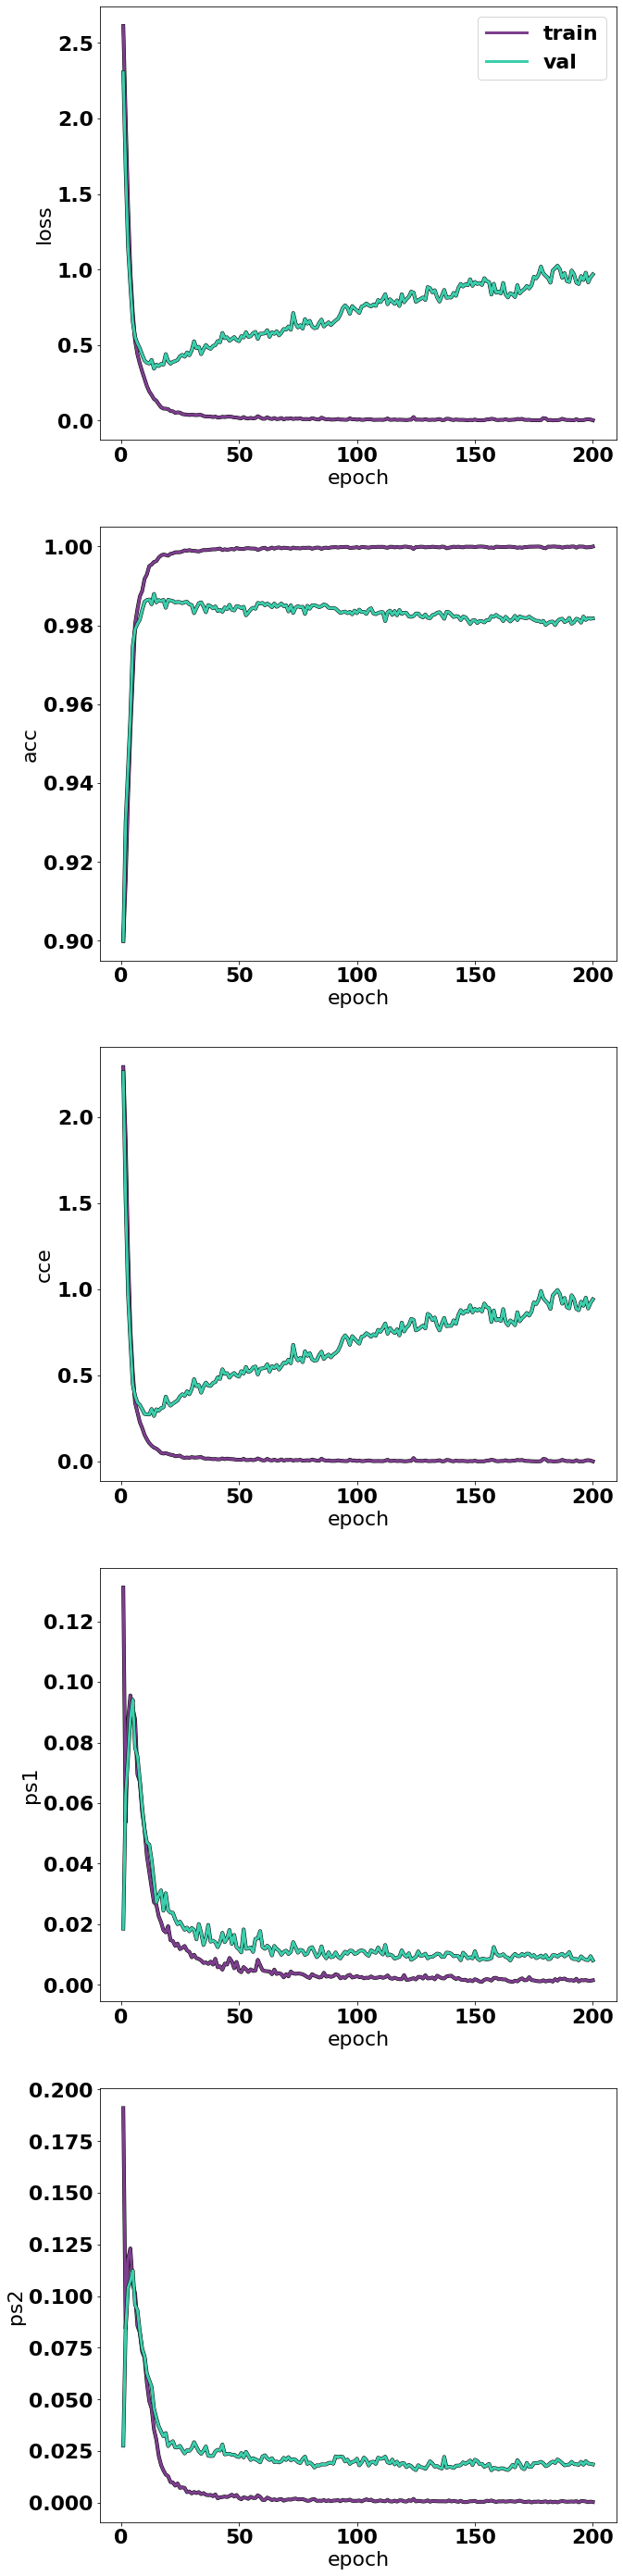

In [21]:
fig = plt.figure(figsize=(10,50))
for j,m in enumerate(['loss', 'acc', 'cce', 'ps1', 'ps2']):
    ax = fig.add_subplot(5,1,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])

### calculate test set accuracy

In [22]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.98184


### calculate activations across the training set

In [23]:
embed1 = tf.keras.Model(inputs=i, outputs=e1)

In [24]:
embed1.layers[1].set_weights(model.layers[1].get_weights())
embed1_activations_by_class = {}
a = embed1.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        embed1_activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed1_activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 980.07it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


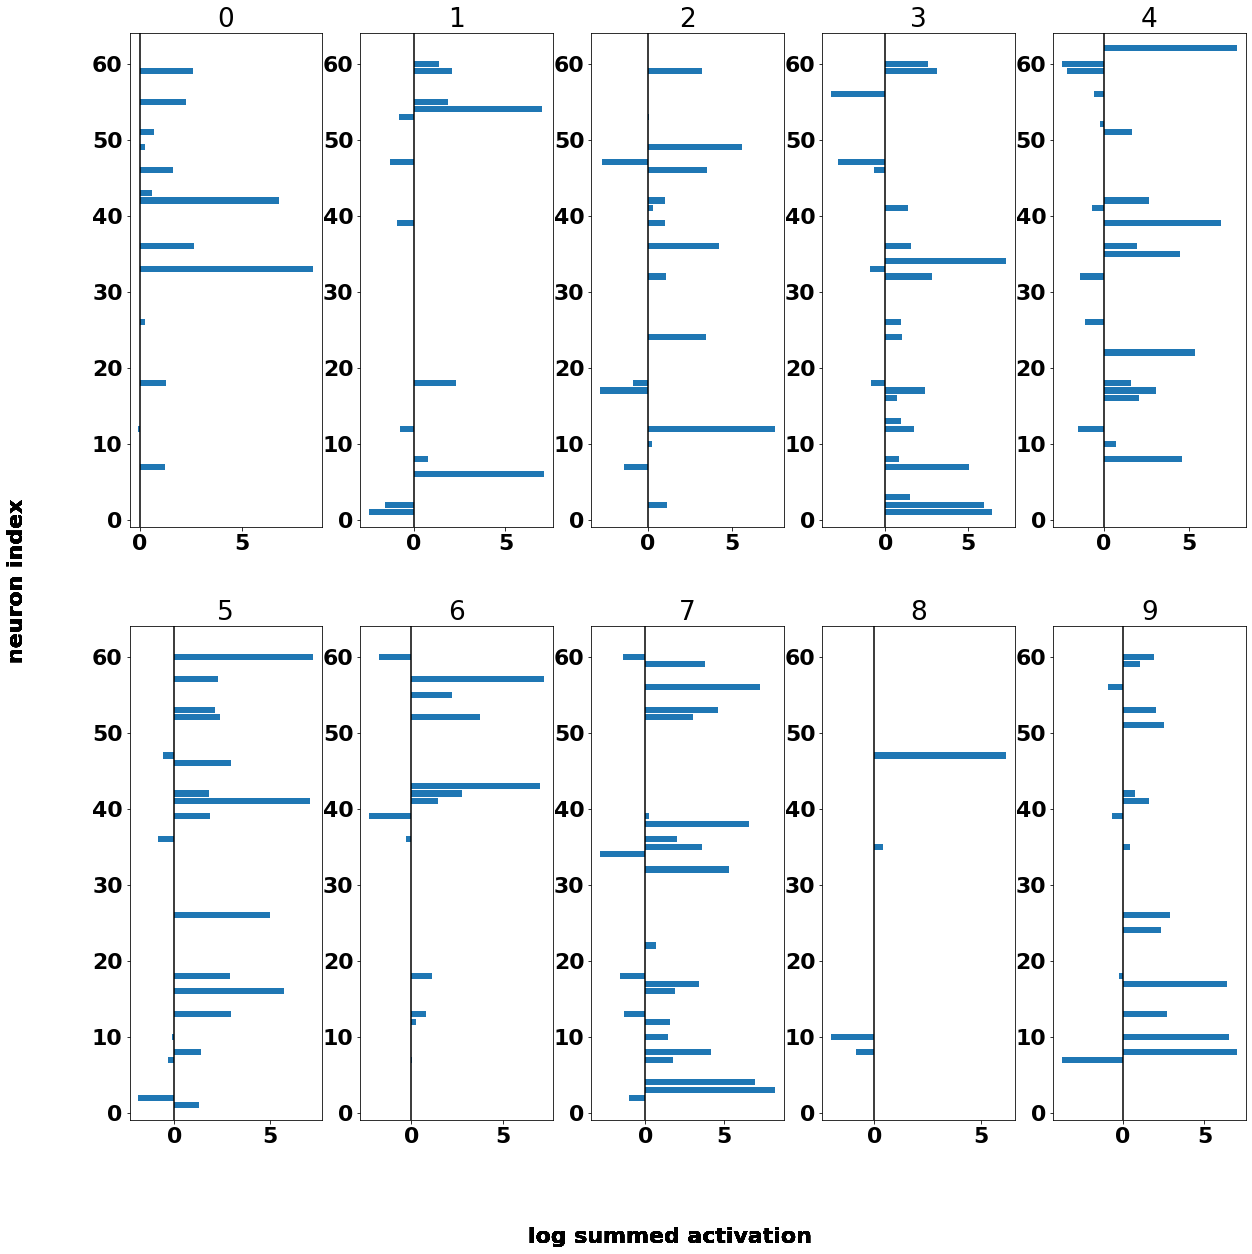

In [25]:
fig = plt.figure(figsize=(20,20))
classes = list(embed1_activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed1_activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed1_activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed1_activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed1_activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

In [29]:
embed2_input = tf.keras.layers.Input(shape=(28*28,))
embed2_hidden1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed2_hidden1')(embed2_input)
embed2_output = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed2_output')(embed2_hidden1)
embed2 = tf.keras.Model(inputs=embed2_input, outputs=embed2_output)

In [30]:
embed2.layers[1].set_weights(model.layers[1].get_weights())
embed2.layers[2].set_weights(model.layers[2].get_weights())
embed2_activations_by_class = {}
a = embed2.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        embed2_activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed2_activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 988.25it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


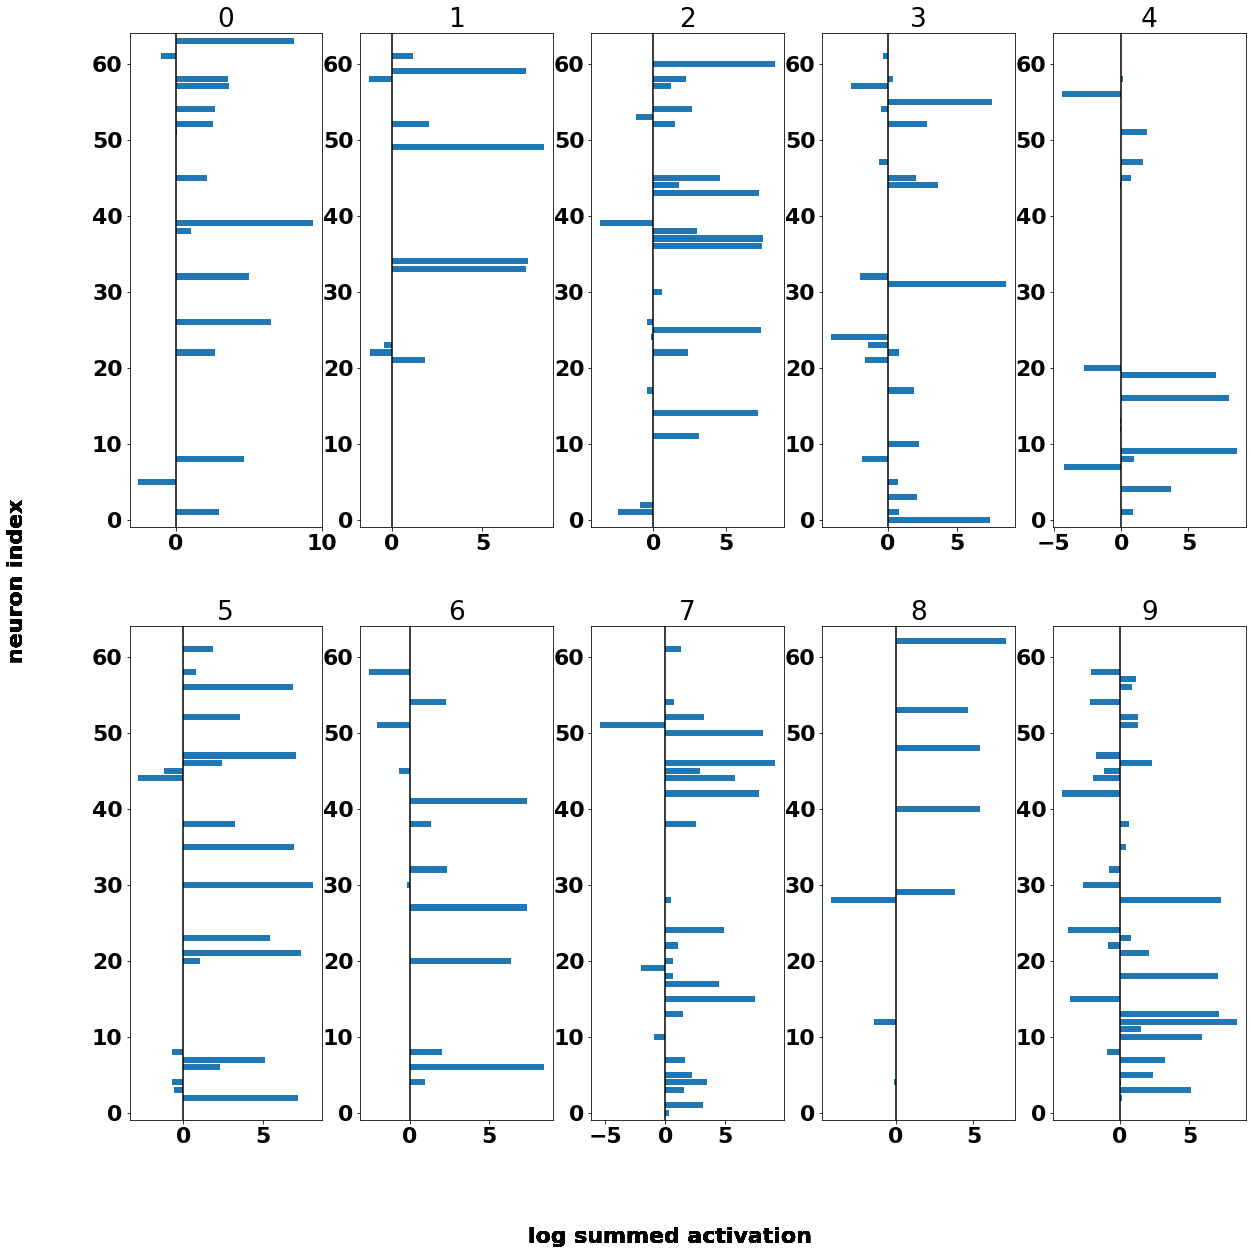

In [31]:
fig = plt.figure(figsize=(20,20))
classes = list(embed2_activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed2_activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed2_activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed2_activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed2_activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### calculate activations across the test set

In [32]:
embed1_activations_by_class_test = {}
a = embed1.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        embed1_activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed1_activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5782.05it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


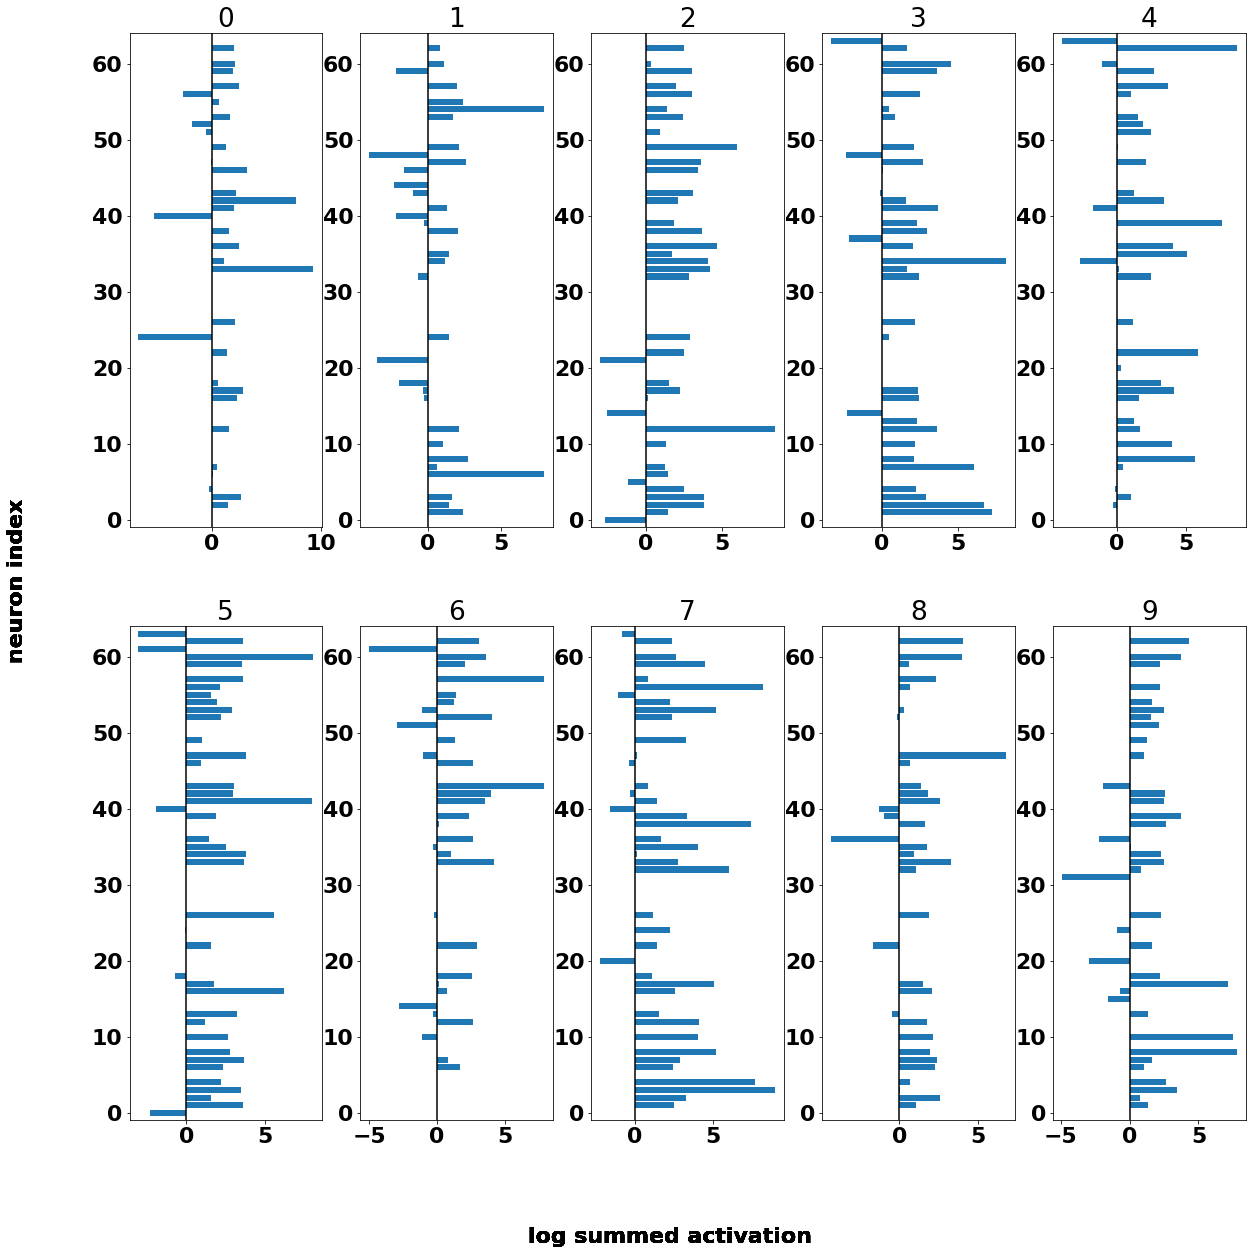

In [34]:
fig = plt.figure(figsize=(20,20))
classes = list(embed1_activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed1_activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed1_activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed1_activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed1_activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

In [35]:
embed2_activations_by_class_test = {}
a = embed2.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        embed2_activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed2_activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5671.27it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


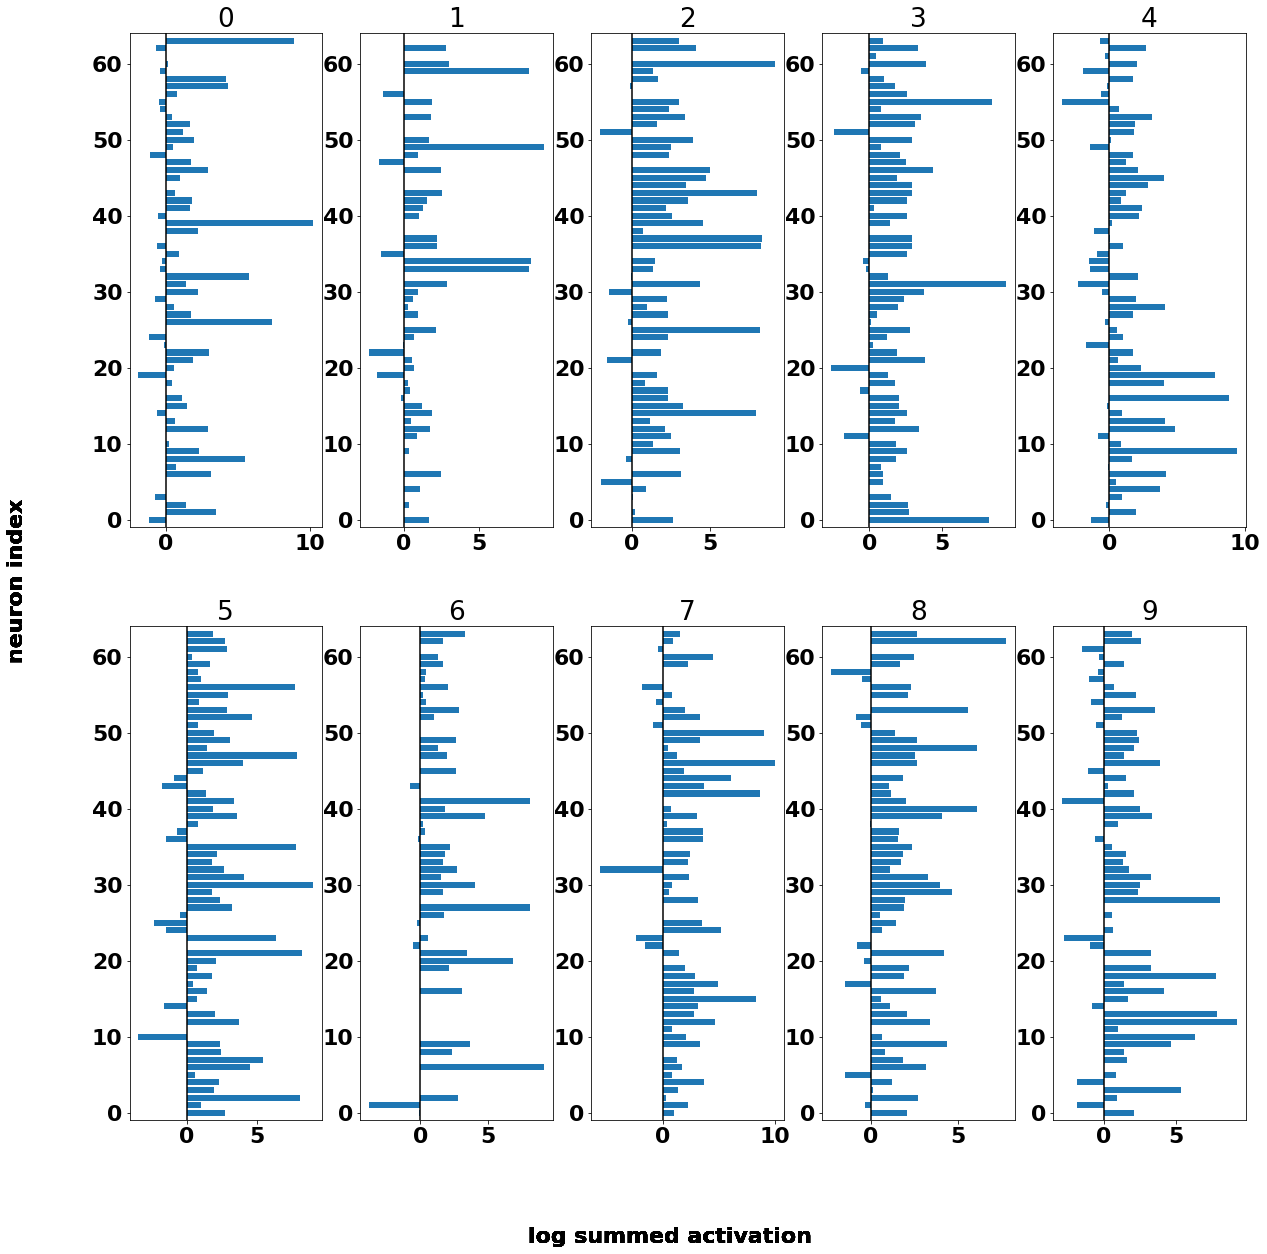

In [36]:
fig = plt.figure(figsize=(20,20))
classes = list(embed2_activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed2_activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed2_activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed2_activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed2_activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [37]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed1_activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(embed1_activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.0031927620168390506


In [38]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed2_activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(embed2_activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.0003078148880671853


### measure degree of polysemantism across test set activations

In [39]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed1_activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(embed1_activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.01854274649683955


In [40]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed2_activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(embed2_activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.00980547071198493


### visualise hidden neurons

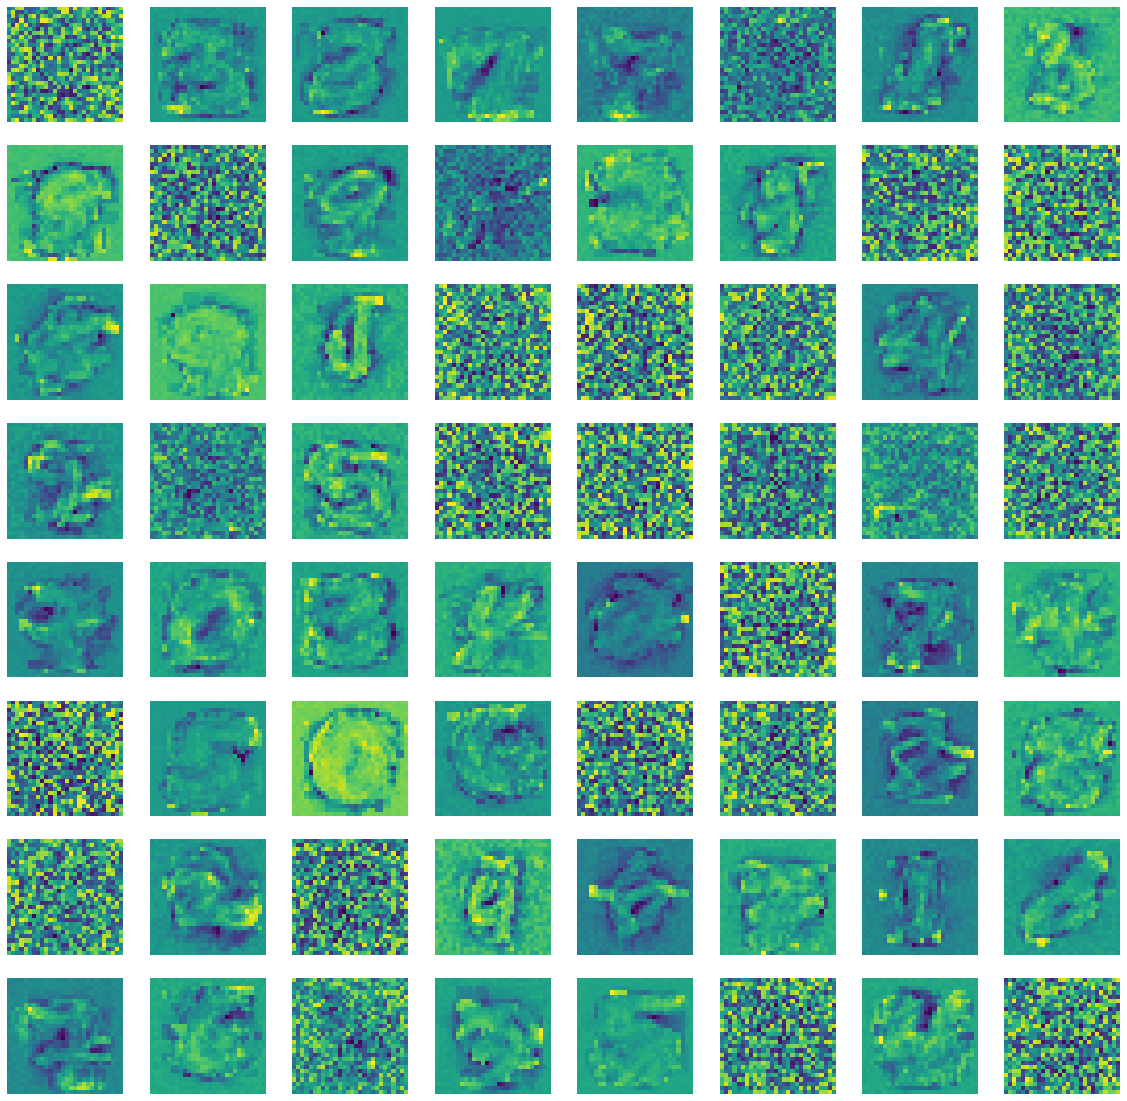

In [41]:
W = model.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((28,28)))
    plt.axis('off')
plt.show()

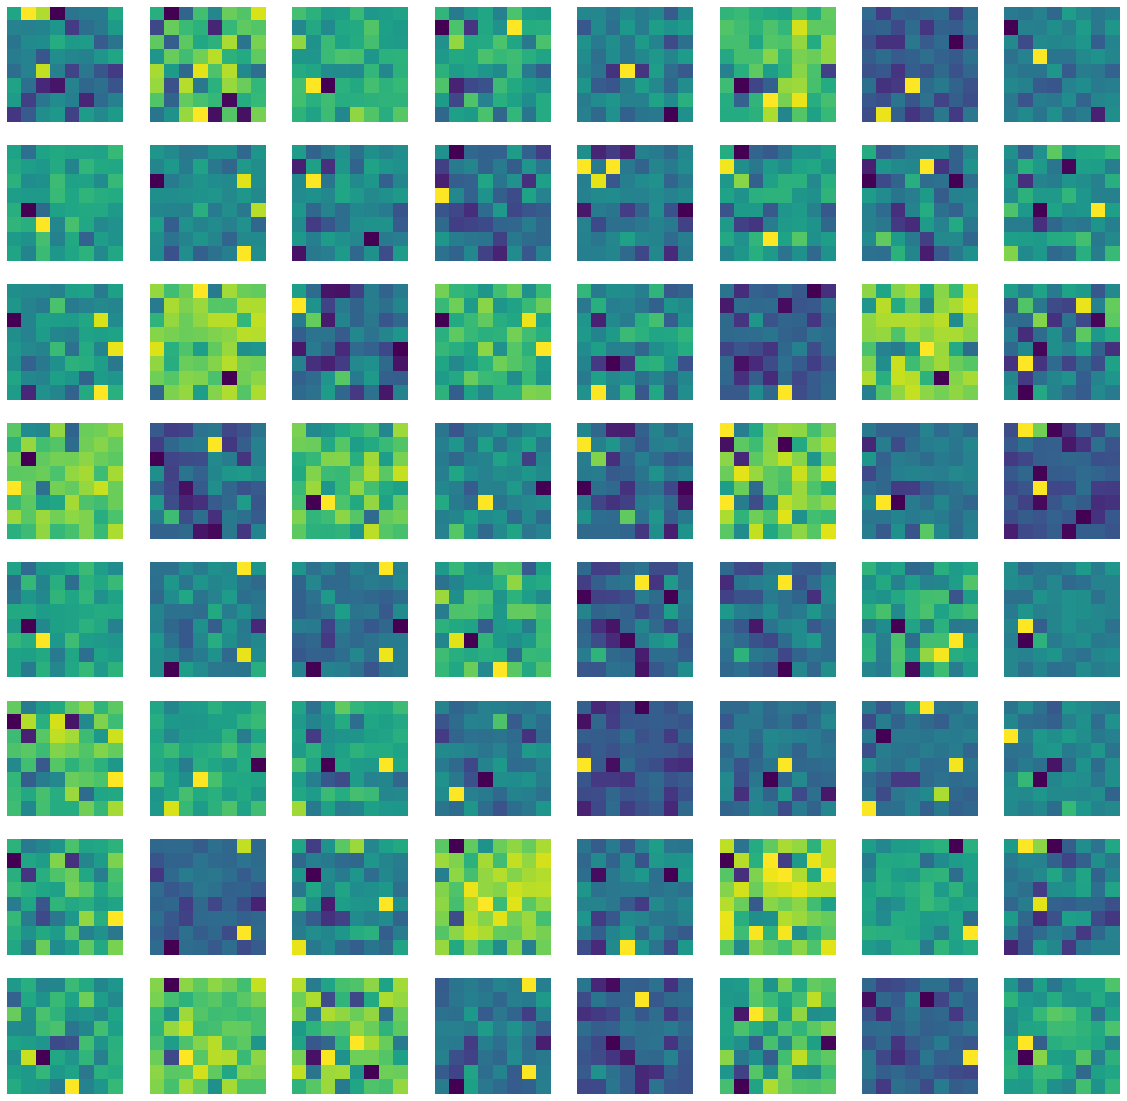

In [43]:
W = model.layers[2].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((8,8)))
    plt.axis('off')
plt.show()